# Helper Functions 
(Run hidden cell)
- Training Accuracy and Loss Graphs:    plot_history(history)
- Predictions:                          print_predictions(inceptionv3_model, test_ds)
- True and Predicted Classes:           true_classes,predicted_classes = true_pred_classes(inceptionv3_model, test_ds)
- Accuracy:                             accuracy_score(true_classes,predicted_classes)
- F1 Score:                             f1_score(true_classes, predicted_classes, average='weighted')
- Recall:                               recall_score(true_classes, predicted_classes, average='weighted')
- Precision:                            precision_score(true_classes, predicted_classes, average='weighted')
- Confusion MAtrix (as Array):          conf_matrix = confusion_matrix(true_classes, predicted_classes)
- Plot Confusion Matrix:                print_conf_matrix(true_classes, predicted_classes,class_names)
- Upload a trained model to azure:      download_model_from_azure("model_name")
- Download a trained model from azure:  upload_model_to_azure(model, "model_name")

In [3]:
image_size=224
channels=3
autotune = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically

def data_split(df):
    """Splits and returns the dataset into training, validation, and test"""
    X_temp, X_test, y_temp, y_test = train_test_split(df['Image_Folder'], df['Label'], test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)
    #convert labels to array
    y_train = np.array(y_train).tolist()
    y_val = np.array(y_val).tolist()
    y_test = np.array(y_test).tolist()
    #print number of observations per datasets
    print("Nr. Training:",len(X_train),"Nr. Validation:",len(X_val),"Nr. Test:",len(X_test))
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def load_image(image_path):
    """Fetches image data from Azure Blob Storage."""
    try:
        # Create a blob service client
        blob_service_client = BlobServiceClient(account_url="https://<account_name>.blob.core.windows.net", credential="<account_key>")
        blob_client = container_client.get_blob_client(image_path)

        # Download the blob's contents as bytes
        blob_data = blob_client.download_blob().readall()
        
        return blob_data
    
    except Exception as e:
        print(f"Error fetching image from Azure: {e}")
        # Return a default image or handle the error appropriately
        return tf.zeros((image_size, image_size, channels), dtype=tf.uint8).numpy()

def load_and_preprocess_image(path):
    """Loads an image, decodes it to grayscale, resizes, and normalizes it."""
    # Load image
    image_file = load_image(path)
    # Decode the image to grayscale
    image_tensor = tf.io.decode_image(image_file, channels=channels)
    # Resize the image
    image_resized = tf.image.resize(image_tensor, [image_size, image_size])
    # Normalize the image data
    image_normalized = image_resized / 255.0
    return image_normalized.numpy()

def create_data_lists(filenames, labels):
    """Creates lists of images and labels."""
    X_train = []
    y_train = []

    for path, label in zip(filenames, labels):
        image = load_and_preprocess_image(path)
        X_train.append(image)
        y_train.append(label)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # Convert labels to one-hot encoding
    #y_train = tf.keras.utils.to_categorical(y_train, num_classes=7)
    
    return X_train, y_train

def create_labels (labels):
    y_labels = []
    for label in labels: 
        y_labels.append(label)
    y_labels = np.array(y_labels)

    return y_labels

def plot_history(model):
    """Plots the accuracy and loss of the inputted model."""
    # summarize history for accuracy
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


def print_predictions(labels, preds, predictions):
    """Predictions based on test dataset."""
    #predict
    for label,pred, prediction in zip(labels, preds, predictions):
        
            print("Prediction:", prediction,"Pred. Class: ",pred, "Actual Label:", label)# Print the first prediction
        
    
        
def plot_model(model): 
    """Plot model with predefined arguments."""
    plot_model(model, 
            to_file='vgg.png',
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            show_layer_activations=True,
            show_trainable=False)
    

def evaluate_model(model, test_ds):
    result = model.evaluate(test_ds)
    # Assuming accuracy was the second metric (index 1), extract the accuracy.
    test_accuracy = result[1] * 100  # Convert to percentage
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


def true_and_predicted_classes(predictions, labels):
    predicted_classes = []
    true_classes = []
    for prediction in predictions:  
        pred = np.argmax(prediction)
        predicted_classes.append(pred)
    for label in labels: 
        true = np.argmax(label)
        true_classes.append(true)
    return predicted_classes, true_classes


def print_conf_matrix(true_classes, predicted_classes):
    """
    Print confusion matrix.
    """
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    df_cm = pd.DataFrame(
        conf_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=(10,7))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')

    # Set aesthetics for better readability
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_image(index, images, labels):
    """
    Plots a single image with its predicted and actual labels.
    
    Parameters:
    - image: The image data to plot.
    - y_true: The true label of the image.
    - y_pred: The predicted label of the image.
    - class_names: List of class names for labels.
    """
    # Get a single image from X_val
    image = images[index]

    # Get the true label for the image
    y_true = np.argmax(labels[index])

    # Predict the label using the model
    y_pred = np.argmax(model.predict(np.expand_dims(image, axis=0)))

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}",
               color='black' if y_true == y_pred else 'red')
    plt.title("Image with Predicted and Actual Labels")
    plt.show()

def plot_wrong_pred_image(images, true_classes, predicted_classes):
    """
    Plots a single image with its predicted and actual labels.
    
    Parameters:
    - image: The image data to plot.
    - y_true: The true label of the image.
    - y_pred: The predicted label of the image.
    - class_names: List of class names for labels.
    """
    mismatch =  [i for i in range(len(true_classes)) if true_classes[i] != predicted_classes[i]]
    random_nr = random.choice(mismatch)
    # Get a single image from X_val
    image = images[random_nr]

    # Get the true label for the image
    y_true = true_classes[random_nr]

    # Predict the label using the model
    y_pred = predicted_classes[random_nr]

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}",
               color='black' if y_true == y_pred else 'red')
    plt.title("Wrong predicted image")
    plt.show()


# Setup

Run the follwing cell to pip install the necerssary packages specified in the requirements.txt file.

In [21]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


to push/pull form ucloud enter following code in terminal
-  git config --global user.name "FIRST_NAME LAST_NAME"
-  git config --global user.email "MY_NAME@example.com"


Importing the necessary packages

In [2]:
import os
import io
import tensorflow as tf
import numpy as np
from azure.storage.blob import BlobServiceClient, ContainerClient
from azure.core.exceptions import ResourceNotFoundError
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import time
from keras.models import load_model
import tempfile

import pandas as pd
from tensorflow.keras import layers, models
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

2024-05-16 08:23:46.783892: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 08:23:46.788515: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 08:23:46.837550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 08:23:47.821583: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Connect to Azure

In [86]:
#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "meterml"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

### Load Image Paths and Labels

In [4]:

#get filepaths
df_train= pd.read_csv("data/FINAL_METER_ML_train_2000.csv")
df_val = pd.read_csv("data/FINAL_METER_ML_val.csv")
df_test = pd.read_csv("data/FINAL_METER_ML_test.csv")

# convert each string in the DataFrame to a list
df_train['Label'] = df_train['Label'].apply(ast.literal_eval).apply(np.array)
df_val['Label'] = df_val['Label'].apply(ast.literal_eval).apply(np.array)
df_test['Label'] = df_test['Label'].apply(ast.literal_eval).apply(np.array)


class_names=["CAFOs","Landfills","Mines","Negative","ProcessingPlants","RefineriesAndTerminals","WWTreatment"]

#X_train = df_train['Image_Folder']
#X_val = df_val['Image_Folder']
#X_test = df_test['Image_Folder']


y_train = np.array(df_train['Label']).tolist()
y_val = np.array(df_val['Label']).tolist()
y_test = np.array(df_test['Label']).tolist()


X_train, y_train = create_data_lists(X_train, y_train)
X_val, y_val = create_data_lists(X_val, y_val)
X_test, y_test = create_data_lists(X_test, y_test)

# Save the array to a file
np.save('x_train.npy', X_train)
np.save('x_test.npy', X_test)
np.save('x_val.npy', X_val)



In [6]:
#import images
import numpy as np 
X_val = np.load('data/x_val.npy')
X_test = np.load('data/x_test.npy')
X_train = np.load('data/x_train.npy')

#create labels
y_val = create_labels(y_val)
y_train = create_labels(y_train)
y_test = create_labels(y_test)

# Models

## ResNet50: 
- https://datagen.tech/guides/computer-vision/resnet-50/
- https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351
- https://medium.com/@ozgunhaznedar/image-classification-on-satellite-images-with-deep-learning-baa9813dde4e
- https://wandb.ai/mostafaibrahim17/ml-articles/reports/The-Basics-of-ResNet50---Vmlldzo2NDkwNDE2#step-4:-building-resnet-50-model

### Transfer Learning

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.2182 - loss: 2.4234 - val_accuracy: 0.3743 - val_loss: 1.6940 - learning_rate: 1.0000e-04
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.3363 - loss: 1.7184 - val_accuracy: 0.3248 - val_loss: 1.7229 - learning_rate: 1.0000e-04
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.3804 - loss: 1.6127 - val_accuracy: 0.2733 - val_loss: 1.9277 - learning_rate: 1.0000e-04
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.4031 - loss: 1.5830 - val_accuracy: 0.4455 - val_loss: 1.4681 - learning_rate: 1.0000e-04
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.4090 - loss: 1.5545 - val_accuracy: 0.4158 - val_loss: 1.5523 - learning_rate: 1.0000e-04
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.4230 - loss: 1.5222 - val_accuracy: 0.4218 - val_loss: 1.4501 - learning_rate: 1.0000e-04
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - acc

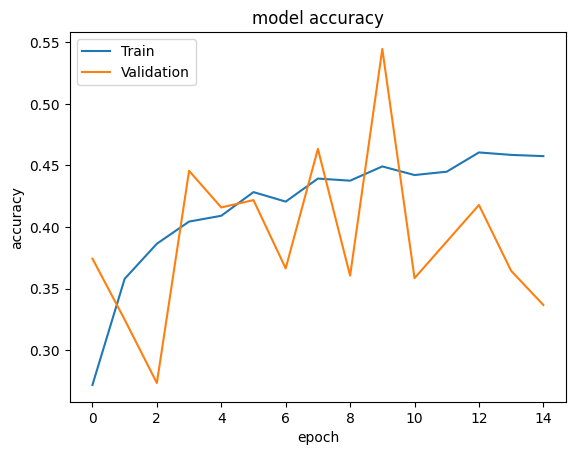

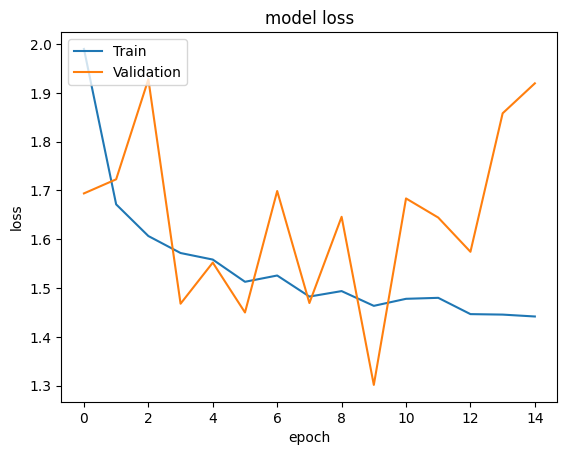

In [7]:
#set variables
train_epochs = 30
tune_epochs = 10
total_epochs = train_epochs + tune_epochs
batch_size = 128

# import resnet model for transfer learning
rn50_base = tf.keras.applications.ResNet50(
    include_top = False,
    weights = "imagenet",
    input_shape=(224,224,3)
    )

# Freeze layers pf basemodel, so the pre-trained weights are fixed
for each_layer in rn50_base.layers:
        each_layer.trainable=False

# create sequential model
resnet_model = Sequential()

# Add output layers for finetuning
resnet_model.add(rn50_base)
resnet_model.add(Flatten()) #use flatten instead of GlobalAveragePooling2D as it may yield better results when enough data
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(7, activation='softmax'))

# Compile model
resnet_model.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
                    loss= tf.keras.losses.CategoricalCrossentropy(), 
                    metrics = ['accuracy'])

#initializt time
t0 = time.time()

# Train model 
history = resnet_model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs = train_epochs, batch_size=batch_size, callbacks = [ReduceLROnPlateau(patience=5), EarlyStopping(patience=5)])

t1 = time.time()

#print time in seconds
print("Training time in seconds:", t1-t0)

#save model
resnet_model.save("resnet_model.keras")

# Plot model information
plot_history(history)


### Fine Tuning

In [8]:
#unfreeze last convolution layer for fine tuning
for each_layer in rn50_base.layers:
        each_layer.trainable=False
for layer in [l for l in rn50_base.layers if 'conv5' in l.name]:
   layer.trainable = True
   
for i, layer in enumerate(rn50_base.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_layer - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_con

Epoch 1/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.3210 - loss: 2.8954 - val_accuracy: 0.5030 - val_loss: 2.8012 - learning_rate: 1.0000e-05
Epoch 2/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.4795 - loss: 1.3919 - val_accuracy: 0.4396 - val_loss: 2.2775 - learning_rate: 1.0000e-05
Epoch 3/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.5396 - loss: 1.2547 - val_accuracy: 0.2554 - val_loss: 1.8606 - learning_rate: 1.0000e-05
Epoch 4/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.5798 - loss: 1.1529 - val_accuracy: 0.3406 - val_loss: 1.7838 - learning_rate: 1.0000e-05
Epoch 5/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.6353 - loss: 1.0327 - val_accuracy: 0.2931 - val_loss: 2.0643 - learning_rate: 1.0000e-05
Epoch 6/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.6854 - loss: 0.9148 - val_accuracy: 0.4673 - val_loss: 1.5664 - learning_rate: 1.0000e-05
Epoch 7/40
110/110 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - acc

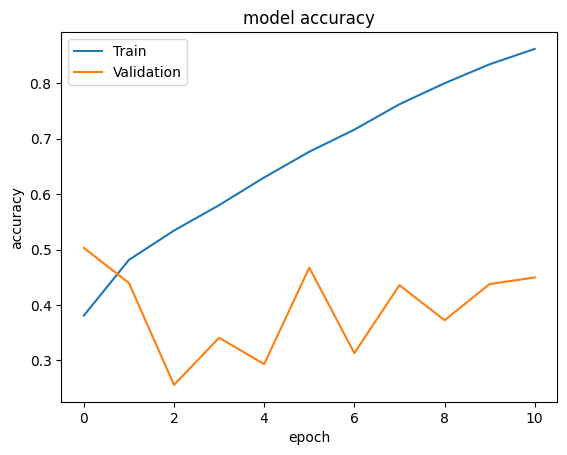

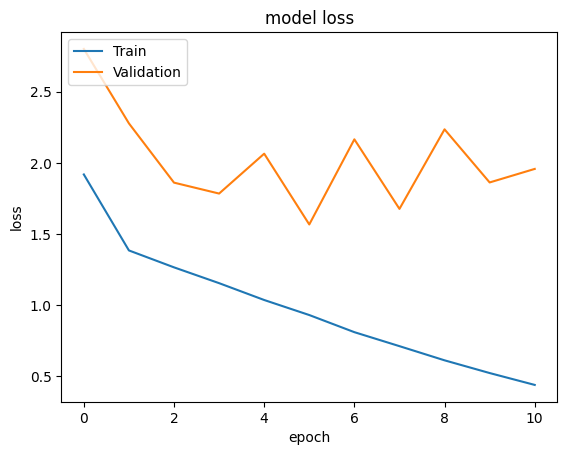

In [9]:
#compile the model with smaller learning rate
resnet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
                    loss = tf.keras.losses.CategoricalCrossentropy(), 
                    metrics=['accuracy'])

#initialize timing
t0 = time.time()

# Train model 
history = resnet_model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=total_epochs,  batch_size=batch_size, callbacks = [ReduceLROnPlateau(patience=5), EarlyStopping(patience=5)])
t1 = time.time()
print("Training time in seconds:", t1-t0)

#save trained model
resnet_model.save("resnet_model_tf.keras")

# Plot training plots
plot_history(history)

# AlexNet

/home/ucloud/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.1900 - loss: 1.9313 - val_accuracy: 0.1842 - val_loss: 1.9416 - learning_rate: 1.0000e-06
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3042 - loss: 1.8100 - val_accuracy: 0.2198 - val_loss: 1.8919 - learning_rate: 1.0000e-06
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.3477 - loss: 1.7306 - val_accuracy: 0.2752 - val_loss: 1.8195 - learning_rate: 1.0000e-06
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.3660 - loss: 1.6813 - val_accuracy: 0.3030 - val_loss: 1.7254 - learning_rate: 1.0000e-06
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3739 - loss: 1.6520 - val_accuracy: 0.2891 - val_loss: 1.7528 - learning_rate: 1.0000e-06
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3892 - loss: 1.6181 - val_accuracy: 0.3327 - val_loss: 1.6586 - learning_rate: 1.0000e-06
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - acc

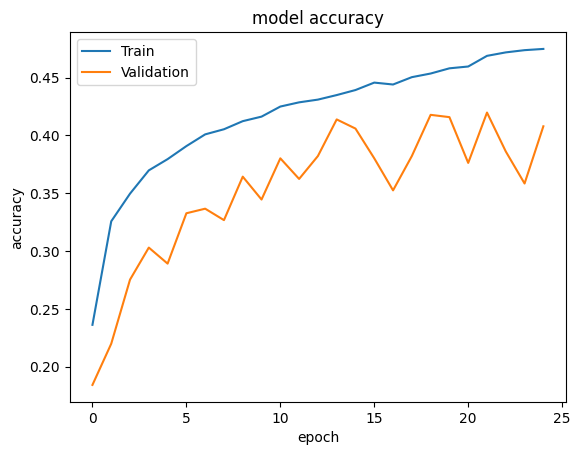

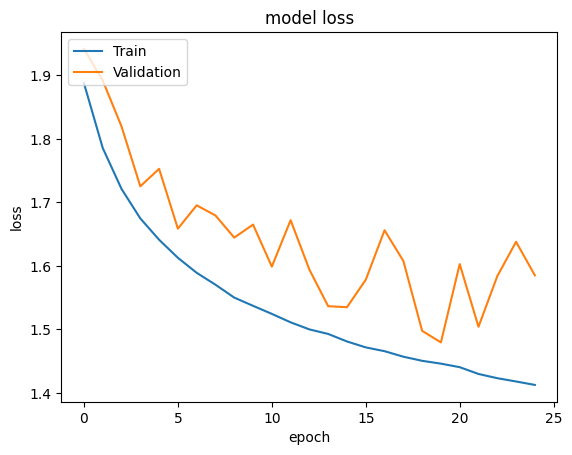

In [9]:
IMG_SIZE = 224
CHANNELS = 3

alexnet = Sequential()

alexnet.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= (224,224,3),
                        kernel_initializer= 'he_normal'))

alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

alexnet.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
                        
alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

alexnet.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

alexnet.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                        padding= 'valid', data_format= None))

alexnet.add(Flatten())
alexnet.add(Dense(4096, activation= 'relu'))
alexnet.add(Dense(4096, activation= 'relu'))

#Output layer with 7 classes insteas of 1000 as in model architecture:
alexnet.add(Dense(7, activation= 'softmax'))


# Compile the model:
alexnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

#initialize timing
t0=time.time()

# Fit model and save history for further analysis:
history = alexnet.fit(X_train,
                      y_train,
                      validation_data = (X_val,y_val), 
                      epochs=30,
                      batch_size=128,
                      callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

print("Training time in seconds:", time.time()-t0)

#save model
alexnet.save('alexnet.keras')

plot_history(history)



## Self-trained VGG16

In [8]:
#Set Variables
epochs = 10
batch_size = 128

# Define Model
_input = Input((224,224,3)) 

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(7, activation="softmax")(dense2) #adapted number of outputs and outputfunction

vgg16_model  = Model(inputs=_input, outputs=output)


#compile the model
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

##provide a model summary
vgg16_model.summary()

#initialize timing
t0=time.time()

#fit the model
history = vgg16_model.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks = [ReduceLROnPlateau(patience=5), EarlyStopping(patience=5)])

t1=time.time()
print("Training time in seconds:", t1-t0)

# save model:
vgg16_model.save("vgg16_model.keras")

#Plot history
plot_history(vgg16_model)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,289,223 (512.27 MB)

 Trainable params: 134,289,223 (512.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1621s 15s/step - accuracy: 0.1490 - loss: 1.9386 - val_accuracy: 0.2317 - val_loss: 1.8480 - learning_rate: 1.0000e-05
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1618s 15s/step - accuracy: 0.3329 - loss: 1.6877 - val_accuracy: 0.3604 - val_loss: 1.5554 - learning_rate: 1.0000e-05
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1622s 15s/step - accuracy: 0.4056 - loss: 1.5546 - val_accuracy: 0.4653 - val_loss: 1.4799 - learning_rate: 1.0000e-05
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1627s 15s/step - accuracy: 0.4505 - loss: 1.4766 - val_accuracy: 0.4535 - val_loss: 1.5284 - learning_rate: 1.0000e-05
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1633s 15s/step - accuracy: 0.4648 - loss: 1.4218 - val_accuracy: 0.3941 - val_loss: 1.6531 - learning_rate: 1.0000e-05
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1638s 15s/step - accuracy: 0.4723 - loss: 1.4030 - val_accuracy: 0.3762 - val_loss: 1.6487 - learning_rate: 1.0000e-05
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1630s 

KeyboardInterrupt: 